In [15]:
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, TypeVar
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)

import cmasher as cmr

In [16]:
INPUT_DIR = OUTPUT_DIR = "/cmlscratch/jkirchen/watermarking-root/lm-watermarking-dev/figure_notebooks"
figure_dir = f"{INPUT_DIR}/figures"

# save = False
save = True

In [17]:
# enumerate data dir and load all csv files into a dataframe
def get_data_df(data_dir=None, data_path=None):

    data_df = pd.DataFrame()
    if data_path is None:
        for file in sorted(os.listdir(data_dir)):
            if file.endswith(".csv"):
                file_path = os.path.join(data_dir, file)
                data = pd.read_csv(file_path)
                data_df = data_df.append(data)
    else:
        data_df = pd.read_csv(data_path)

    return data_df

In [18]:
def plot_scatter_data(data_df, x_col="x", y_col="y",x_name=None,y_name=None, series_readable_id_col="name", series_readable_id_map=None, special_color_map=None, color_marker_map=None, num_colors=None, num_markers=None, num_cols=None, filter_list=None, legend_sort_indices=None, shorten_legend_indices=None, legend_unique_indices=None, plot_unique_indices=None, legend_title=None, x_lim=None, x_tick_spec=None, y_lim=None, y_tick_spec=None, title="Figure Title", marker_size=None,figure_size=None,legend_loc=None, grid=True, save_path=None, show=True):
    
    # give each point a unique marker and color
    # make a random colormap
    cmap = cmr.take_cmap_colors("cmr.rainforest", (len(data_df) if num_colors is None else num_colors), cmap_range=(0.2, 0.8), return_fmt="hex")
    # markers = ["*", "s", "^", "p", "v", "<", "P", ">", "h", "H", "+",  "X", "D",  "|", "d", "x", "_", "o"]
    markers = ["*", "s",  "X", "D",  "P", ">", "h", "^","v", "p", "<", "H", "+", "d", "x", "p"]


    if num_markers is not None:
        markers = markers[:num_markers]
    
    all_possible_color_and_marker_combos = [(color, marker) for color in cmap for marker in markers]
    
    #plot using plt.scatter
    marker_size = marker_size
    fig, ax = plt.subplots(figsize=figure_size)
    
    # sort data_df by series_readable_id_col
    # data_df = data_df.sort_values(by=[series_readable_id_col])

    if filter_list is not None:
        # remove data where series_readable_id_map[row[series_readable_id_col]] is in filter_list
        # print(f"Col for filtering:{data_df[series_readable_id_col].apply(series_readable_id_map)[0]}")
        data_df = data_df[~data_df[series_readable_id_col].apply(series_readable_id_map).isin(filter_list)]

    labels_so_far = set()

    for i, row in data_df.iterrows():

        if isinstance(series_readable_id_map, dict):
            label = series_readable_id_map[row[series_readable_id_col]]
        elif isinstance(series_readable_id_map, Callable):
            # print(row[series_readable_id_col])
            label = series_readable_id_map(row[series_readable_id_col])
            # print(label)
        else:
            label = row[series_readable_id_col]

        # enforce the uniqueness condition based on the plot_unique_indices and labels_so_far
        # note, this is not the same as the legend_unique_indices
        if plot_unique_indices is not None:
            label_tup = label.split(",")
            label_tup = tuple([label_tup[i] for i in plot_unique_indices])
            if label_tup in labels_so_far:
                continue
            else:
                labels_so_far.add(label_tup)

        
        if color_marker_map is not None and isinstance(color_marker_map, Callable):
            # print(f"Using color marker callable")
            color_idx, marker_idx = color_marker_map(series_readable_id_map(row[series_readable_id_col]))
            if isinstance(color_idx,int):
                color = cmap[color_idx]
            else:
                color = color_idx
            if isinstance(marker_idx,int):
                marker = markers[marker_idx]
            else:
                marker = marker_idx
            # print(f"color: {color}, marker: {marker}")
        else:
            if special_color_map and row[series_readable_id_col] in special_color_map.keys():
                if isinstance(special_color_map[row[series_readable_id_col]], int):
                    color = cmap[special_color_map[row[series_readable_id_col]]]
                else:
                    color = special_color_map[row[series_readable_id_col]]
            else:
                # color = cmap[i]
                color = all_possible_color_and_marker_combos[i][0]
            # marker = markers[i]
            marker = all_possible_color_and_marker_combos[i][1]

        ax.scatter(row[x_col], row[y_col], label=label, color=color, marker=marker, alpha=0.8, sizes=[marker_size])
    
    # sort legend the value of y_col and then x_col
    handles, labels = ax.get_legend_handles_labels()
    x_vals = data_df[x_col]
    y_vals = data_df[y_col]

    if legend_sort_indices is not None:
        label_tups = [lab.split(",") for lab in labels]

        # try to convert each elm in sort indices for each tup to int
        # if it fails, then it is a string
        for tup in label_tups:
            for idx in legend_sort_indices:
                try:
                    tup[idx] = int(tup[idx])
                except:
                    pass

        # label_tups = [tuple([lab[i] for i in legend_name_indices]) for lab in label_tups]
        # sort by label_tups in their order
        # handles, label_tups, x_vals, y_vals = zip(*sorted(zip(handles, label_tups, x_vals, y_vals), key=lambda t: [[t[1][i] for i in legend_sort_indices],t[2]], reverse=False))
        handles, label_tups, x_vals, y_vals = zip(*sorted(zip(handles, label_tups, x_vals, y_vals), key=lambda t: ([[t[1][i] for i in legend_sort_indices],t[2]] if t[1][0] != "simple" else [["00000",-1],-1]), reverse=False))
        if legend_unique_indices:
            legend_dict = {tuple([label_tup[i] for i in legend_unique_indices]): [handle,label_tup] for handle,label_tup in zip(handles,label_tups)}
            handles, label_tups = zip(*legend_dict.values())
        if shorten_legend_indices:
            label_tups = [[lab[i] for i in shorten_legend_indices] for lab in label_tups]
        # labels = [",".join(lab) for lab in label_tups]
        labels = [",".join([str(elm) for elm in lab]) for lab in label_tups]
        legend_title = legend_title if legend_title else f""
    else:
        # sort by x/y_vals
        handles, labels, _, _ = zip(*sorted(zip(handles, labels, x_vals, y_vals), key=lambda t: (t[3],t[2]), reverse=True))
        # legend_title = f"(Sorted desc. by {y_name if y_name else y_col})"
        legend_title = legend_title if legend_title else f"(Sorted desc. by {y_name if y_name else y_col})"


    # sort by labels if num_cols more than 1, make the legend outside the plot to the RHS
    # and increase marker size
    if num_cols > 1:
        # ax.legend(handles, labels, bbox_to_anchor=(1.04,0.5), loc="center left", ncol=num_cols)
        # make legend taller
        ax.legend(handles, labels, bbox_to_anchor=(1.04,0.5), loc="center left", ncol=num_cols, handletextpad=0.1, columnspacing=0.2, title=legend_title,  title_fontsize=12, fontsize=12)
    else:
        ax.legend(handles, labels,loc=legend_loc, ncol=(num_cols if num_cols is not None else 1), title=legend_title, title_fontsize=12,fontsize=12)
    
    # set title
    plt.title(title)
    # label axes
    plt.xlabel(x_name if x_name else x_col)
    plt.ylabel(y_name if y_name else y_col)

    # set x/y limits
    if x_lim:
        plt.xlim(x_lim)
    if y_lim:
        plt.ylim(y_lim)
    if x_tick_spec is not None:
        ax.set_xticks(x_tick_spec)
    if y_tick_spec is not None:
        ax.set_yticks(y_tick_spec)

    # turn on grid
    ax.grid(grid)

    # tight
    plt.tight_layout()
    # save figure
    if save_path:
        # make if doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        if save_path.endswith(".pdf"):
            plt.savefig(save_path,format="pdf")
        elif save_path.endswith(".png"):
            plt.savefig(save_path,format="png")

    # show figure
    if show:
        plt.show()



In [19]:
def name_extractor(x):

    is_not_run_length_specd = "%_eval" in x
    
    x = x.replace("core_simple_1_100_600_gen_cp_attack_", "")
    # x = x.replace("%_F_succ_T_runs", "%-F_succ_T_runs")
    # x = x.replace("%_T_and_F_runs", "%-T_and_F_runs")
    x = x.replace("%_F_succ_T_runs", "%-Gr Runs")
    x = x.replace("%_T_and_F_runs", "%-Gr+R Runs")
    x = x.replace("%_eval", "%")

    if is_not_run_length_specd:
        # x += "-F_succ_T_runs-max_plus_1-True-0-pearson"
        x += "-Gr Runs-max_plus_1-True-0-pearson"

    tup_x = x.split("-")
    # tup_x[-1] = tup_x[-1].replace("-", ".")
    # tup_x[-2] = tup_x[-2].replace("-", ".")
    
    # tup_x[1] = str(100-int(tup_x[1].replace("%",""))) + "%"
    tup_x[1] = str(100-int(tup_x[1].replace("%","")))

    return ",".join(tup_x)


In [20]:
fig_name = "detector_cp_perc_auc_scatter"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)

# drop where the attack percentage is < 50
df = df[df["cp_attack_effective_attack_percentage"] >= 50]
df

,Name,cp_attack_effective_attack_percentage,attacked_z_score_roc_auc,_wandb
0,core_simple_1_100_600_gen_cp_attack_5-50%_eval,50,0.998331,NaN
1,core_simple_1_100_600_gen_cp_attack_5-5%_T_and...,95,0.657927,NaN
2,core_simple_1_100_600_gen_cp_attack_5-5%_T_and...,95,0.657927,NaN
3,core_simple_1_100_600_gen_cp_attack_5-5%_T_and...,95,0.657927,NaN
4,core_simple_1_100_600_gen_cp_attack_5-5%_T_and...,95,0.657927,NaN
...,...,...,...,...
150,core_simple_1_100_600_gen_cp_attack_1-10%_F_su...,90,0.826168,NaN
151,core_simple_1_100_600_gen_cp_attack_1-10%_F_su...,90,0.826168,NaN
152,core_simple_1_100_600_gen_cp_attack_1-10%_F_su...,90,0.826168,NaN
153,core_simple_1_100_600_gen_cp_attack_1-10%_F_su...,90,0.826168,NaN


In [21]:
# name_col = df["Name"]
name_col = df["Name"].apply(name_extractor)
name_col

0             5,50,Gr Runs,max_plus_1,True,0,pearson
1           5,95,Gr+R Runs,max_plus_1,True,2,pearson
2      5,95,Gr+R Runs,max_plus_1,True,2,cressie_read
3           5,95,Gr+R Runs,max_plus_1,True,1,pearson
4      5,95,Gr+R Runs,max_plus_1,True,1,cressie_read
                           ...                      
150          1,90,Gr Runs,max_plus_1,False,1,pearson
151     1,90,Gr Runs,max_plus_1,False,1,cressie_read
152          1,90,Gr Runs,max_plus_1,False,0,pearson
153     1,90,Gr Runs,max_plus_1,False,0,cressie_read
154           1,90,Gr Runs,max_plus_1,True,0,pearson
Name: Name, Length: 153, dtype: object

In [22]:
# (num_insertions, insertion_percentage,[counting_scheme, bin_scheme, mask_zeros, mask_leading_bins, test_type])

In [23]:
color_order = [
    1,
    3,
    5,
    10,
    20,
]

marker_order = color_order


def color_marker_map(x):

    x_tup = x.split(",")
    assert len(x_tup) == 7

    num_insertions = int(x_tup[0])
    # insertion_percentage = x_tup[1]
    # counting_scheme = x_tup[2]
    # bin_scheme = x_tup[3]
    # mask_zeros = x_tup[4]
    # mask_leading_bins = x_tup[5]
    # test_type = x_tup[6]

    color = color_order.index(num_insertions)
    marker = marker_order.index(num_insertions)

    return color, marker

filter_list = []
    

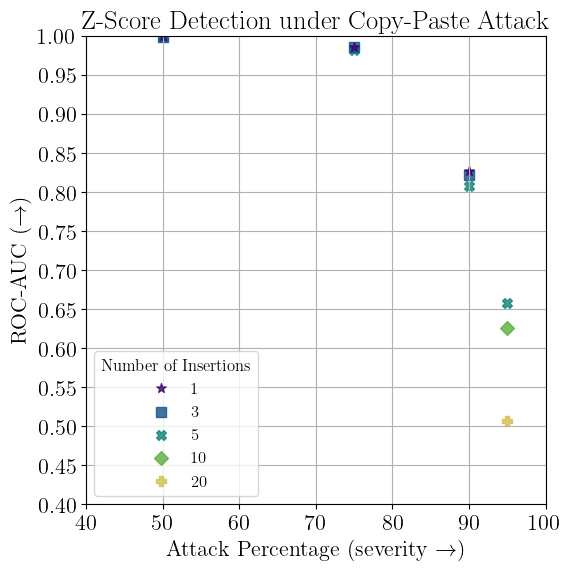

In [24]:
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})

plot_scatter_data(
    data_df=df,
    x_col="cp_attack_effective_attack_percentage",
    y_col="attacked_z_score_roc_auc",
    x_name=r"Attack Percentage (severity $\rightarrow$)",
    y_name=r"ROC-AUC $(\rightarrow)$",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[1,0],
    plot_unique_indices = [0,1],
    legend_unique_indices = [0],
    shorten_legend_indices = [0],
    x_lim=(40,100),
    y_lim=(0.4,1.0),
    y_tick_spec=np.arange(0.4,1.04,0.05),
    filter_list=filter_list,
    num_colors=5,
    num_markers=5,
    num_cols=1,
    marker_size=50,
    figure_size=(6,6),
    legend_loc="lower left",
    legend_title="Number of Insertions",
    title="Z-Score Detection under Copy-Paste Attack",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [25]:
fig_name = "detector_cp_perc_auc_winmax_scatter"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)

# drop where the attack percentage is < 50
df = df[df["cp_attack_effective_attack_percentage"] >= 50]
df

,Name,cp_attack_effective_attack_percentage,attacked_winmax-1_z_score_roc_auc,_wandb
0,core_simple_1_100_600_gen_cp_attack_5-50%_eval,50,0.998271,NaN
1,core_simple_1_100_600_gen_cp_attack_5-5%_eval,95,0.646539,NaN
2,core_simple_1_100_600_gen_cp_attack_5-25%_eval,75,0.986632,NaN
3,core_simple_1_100_600_gen_cp_attack_5-10%_eval,90,0.836206,NaN
5,core_simple_1_100_600_gen_cp_attack_3-50%_eval,50,0.998082,NaN
6,core_simple_1_100_600_gen_cp_attack_3-25%_eval,75,0.992175,NaN
7,core_simple_1_100_600_gen_cp_attack_3-10%_eval,90,0.895655,NaN
8,core_simple_1_100_600_gen_cp_attack_20-5%_eval,95,0.505192,NaN
9,core_simple_1_100_600_gen_cp_attack_10-5%_eval,95,0.581537,NaN
11,core_simple_1_100_600_gen_cp_attack_1-50%_eval,50,0.998201,NaN


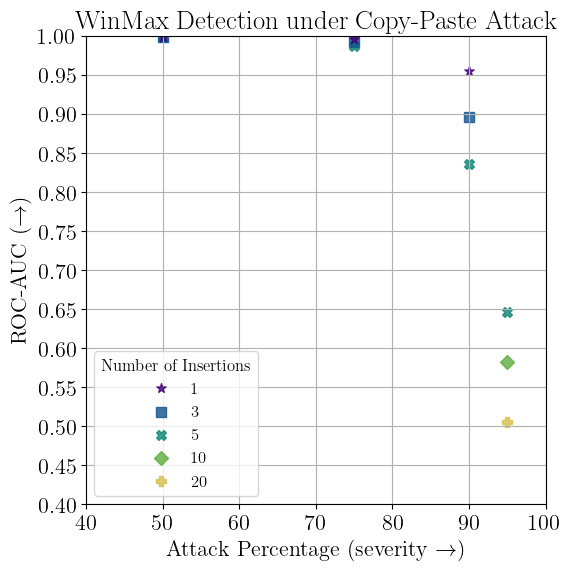

In [26]:
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})

plot_scatter_data(
    data_df=df,
    x_col="cp_attack_effective_attack_percentage",
    y_col="attacked_winmax-1_z_score_roc_auc",
    x_name=r"Attack Percentage (severity $\rightarrow$)",
    y_name=r"ROC-AUC $(\rightarrow)$",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[1,0],
    plot_unique_indices = [0,1],
    legend_unique_indices = [0],
    shorten_legend_indices = [0],
    x_lim=(40,100),
    y_lim=(0.4,1.0),
    y_tick_spec=np.arange(0.4,1.04,0.05),
    filter_list=filter_list,
    num_colors=5,
    num_markers=5,
    num_cols=1,
    marker_size=50,
    figure_size=(6,6),
    legend_loc="lower left",
    legend_title="Number of Insertions",
    title="WinMax Detection under Copy-Paste Attack",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)

In [27]:
fig_name = "detector_cp_perc_auc_runlen_scatter"

data_dir = f"{INPUT_DIR}/figure_data/{fig_name}"

df = get_data_df(data_dir)

# drop where the attack percentage is < 50
df = df[df["cp_attack_effective_attack_percentage"] >= 50]
# df

# use the name extractor to get the name and add each field as a column
df["Orig_Name"] = df["Name"]
df["Name"] = df["Name"].apply(name_extractor)
df["num_insertions"] = df["Name"].apply(lambda x: int(x.split(",")[0]))
df["insertion_percentage"] = df["Name"].apply(lambda x: int(x.split(",")[1]))
df["counting_scheme"] = df["Name"].apply(lambda x: x.split(",")[2])
df["bin_scheme"] = df["Name"].apply(lambda x: x.split(",")[3])
df["mask_zeros"] = df["Name"].apply(lambda x: x.split(",")[4])
df["mask_leading_bins"] = df["Name"].apply(lambda x: x.split(",")[5])
df["test_type"] = df["Name"].apply(lambda x: x.split(",")[6])
df["Name"] = df["Orig_Name"]


topk = 1
# topk = 2
# topk = 3
# topk = 5
# topk = 10
# now group by the attack percentage and the number of insertions
# and only keep the top 5 for each group by the run length statistic auc
df = df.groupby(["cp_attack_effective_attack_percentage", "num_insertions"]).apply(
    lambda x: x.nlargest(topk, "attacked_run_len_chisqrd_statistic_roc_auc")
)

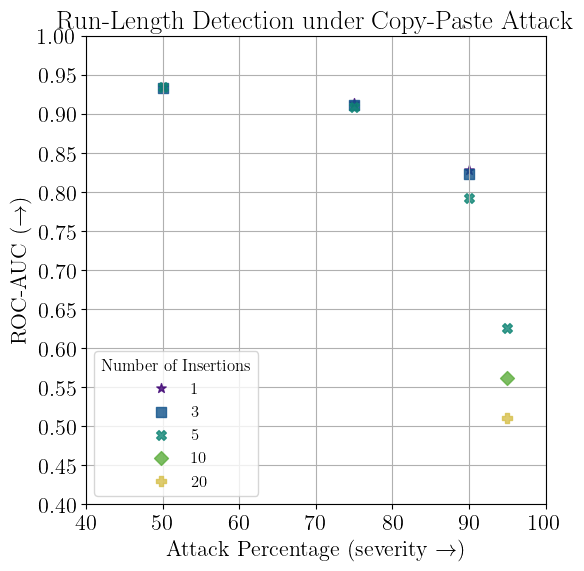

In [28]:
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 13})

plot_scatter_data(
    data_df=df,
    x_col="cp_attack_effective_attack_percentage",
    y_col="attacked_run_len_chisqrd_statistic_roc_auc",
    x_name=r"Attack Percentage (severity $\rightarrow$)",
    y_name=r"ROC-AUC $(\rightarrow)$",
    series_readable_id_col="Name",
    series_readable_id_map=name_extractor,
    color_marker_map=color_marker_map,
    legend_sort_indices=[1,0],
    # plot_unique_indices = [0,1],
    # plot_unique_indices = [0,1,2],
    legend_unique_indices = [0],
    # shorten_legend_indices = [0,4,5],
    shorten_legend_indices = [0],
    x_lim=(40,100),
    y_lim=(0.4,1.0),
    y_tick_spec=np.arange(0.4,1.04,0.05),
    filter_list=filter_list,
    num_colors=5,
    num_markers=5,
    num_cols=1,
    # num_cols=2,
    marker_size=50,
    # figure_size=(15,6),
    figure_size=(6,6),
    legend_loc="lower left",
    # legend_title="Run Length Test Spec (counting scheme, bin scheme, mask zeros, mask leading bins, test type)",
    legend_title="Number of Insertions",
    title="Run-Length Detection under Copy-Paste Attack",
    save_path=f"{figure_dir}/{fig_name}.pdf" if save else None,
)